In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d
import copy

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})
def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

import random

In [44]:
def make_single_plot(H, process_name, cut_name, vmax=None):
    """
    Plot a single 2D histogram for one process
    
    Parameters:
    -----------
    H : 2D numpy array
        The histogram data to plot
    process_name : str
        Name of the process (e.g., 'ggHH', 'ZZ', etc.)
    cut_name : str
        Name for the output file
    vmax : float, optional
        Maximum value for color scale. If None, uses the max of H
    """
    process_labels = {
        'ggHH': r"$gg$F $HH\rightarrow 4b$",
        'ZH': "$ZH$",
        'ZZ': "$ZZ$",
        'QCD': "QCD",
        'TTbar': r'$t\bar{t}$',
        'ZJetsToQQ': r'$Z+\mathrm{jets}$' 
    }
    
    shrink_size = 0.8
    
    x_start, x_end = 70, 170
    y_start, y_end = 70, 170
    
    bins = np.arange(40, 201, 10)
    _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])
    
    x_low_idx = np.where(xedges >= x_start)[0][0]
    x_high_idx = np.where(xedges <= x_end)[0][-1]
    y_low_idx = np.where(yedges >= y_start)[0][0]
    y_high_idx = np.where(yedges <= y_end)[0][-1]
    
    H_cropped = H[x_low_idx:x_high_idx, y_low_idx:y_high_idx]
    
    H_sum = np.sum(H_cropped)
    if H_sum > 0:
        H_norm = H_cropped / H_sum
    else:
        H_norm = H_cropped
    
    xedges_cropped = xedges[x_low_idx:x_high_idx+1]
    yedges_cropped = yedges[y_low_idx:y_high_idx+1]
    
    fig, ax = plt.subplots(figsize=(5, 4.5))
    
    vmax_value = vmax if vmax is not None else np.max(H_norm)
    
    mesh = ax.pcolormesh(xedges_cropped, yedges_cropped, H_norm.T, 
                        shading='flat', cmap='Reds', vmax=vmax_value, vmin=0)
    cbar = fig.colorbar(mesh, ax=ax, label='Normalized count', shrink=shrink_size)
    cbar.set_label('Normalized count', fontsize=13)
    cbar.ax.tick_params(labelsize=11)
    
    ax.set_xlim(x_start, x_end)
    ax.set_ylim(y_start, y_end)
    ax.set_xlabel(r'$m_{h_1} \mathrm{(GeV)}$', fontsize=15)
    ax.set_ylabel(r'$m_{h_2} \mathrm{(GeV)}$', fontsize=15)
    ax.set_title(process_labels.get(process_name, process_name), fontsize=15)
    ax.set_aspect('equal', 'box')
    
    plt.tight_layout()
    
    output_name = f"{cut_name}_{process_name}"
    plt.savefig(f"PLOTS/{output_name}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"PLOTS/{output_name}.pdf", dpi=300, bbox_inches='tight')
    plt.show()



Processing QCD...
Found 557 files for QCD
  [557/557] Processing ensemble_method2_QCD_mergeid13.rootroot

Total events collected: 631656
Total weight: 4618218.64

Final peaks histogram sum: 4618218.64
Original peaks histogram sum: 4618218.64


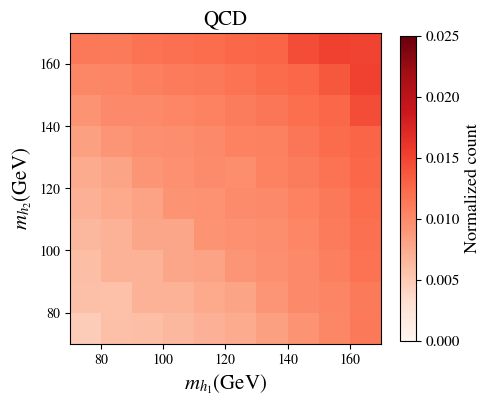

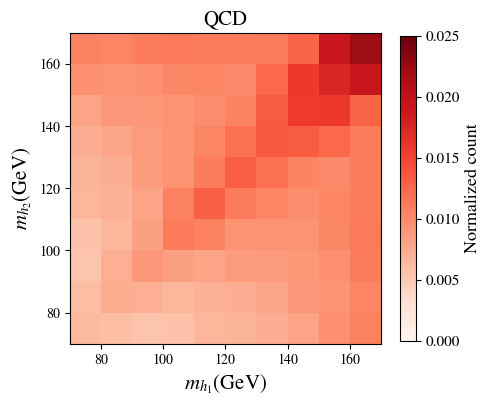

In [45]:
import numpy as np
import awkward as ak
import uproot
import glob
import os
import matplotlib.pyplot as plt

# ===== Configuration =====
ntuple_base_dir = "/data/bond/tyyang99/HH4b/ensemble_method2_ntuples_cdfv2"

lumi_scale = 4.5  # 450 fb^-1

weight_dict = {
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
}

cut_value = 0.9
cut_name = f"cut{str(cut_value).replace('.','p')}"

discriminant = 'score_hh4bvsboth'

proc_name = 'QCD'
bins = np.arange(40, 210, 10)

# ===== Process QCD for both final and original peaks =====
print(f"\n{'='*80}")
print(f"Processing {proc_name}...")
print(f"{'='*80}")

proc_dir = os.path.join(ntuple_base_dir, proc_name)

if not os.path.exists(proc_dir):
    print(f"Warning: Directory not found for {proc_name}")
else:
    all_x_final = []
    all_y_final = []
    all_x_original = []
    all_y_original = []
    all_weights = []
    
    weight = weight_dict[proc_name]
    
    ntuple_files = glob.glob(os.path.join(proc_dir, "ensemble_method2_*.root"))
    
    print(f"Found {len(ntuple_files)} files for {proc_name}")
    
    for f_id, ntuple_file in enumerate(ntuple_files):
        try:
            print(f"\r  [{f_id+1}/{len(ntuple_files)}] Processing {os.path.basename(ntuple_file)}", end='')
            
            with uproot.open(ntuple_file) as f:
                tree = f["tree"]
                data = tree.arrays([
                    f'model0_{discriminant}',
                    f'model1_{discriminant}',
                    f'model2_{discriminant}',
                    'combined_basic_fit_cut',
                    'ensemble_final_peak_x',
                    'ensemble_final_peak_y',
                    'ensemble_original_peak_x',
                    'ensemble_original_peak_y',
                    'weight'
                ])
            
            cut_mask = data['combined_basic_fit_cut'] == 1
            
            if ak.sum(cut_mask) == 0:
                continue
            
            scores_model0 = data[f'model0_{discriminant}'][cut_mask]
            scores_model1 = data[f'model1_{discriminant}'][cut_mask]
            scores_model2 = data[f'model2_{discriminant}'][cut_mask]
            
            ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
            
            score_cut = ensemble_scores > cut_value
            
            if ak.sum(score_cut) == 0:
                continue
            
            peak_x_final = ak.to_numpy(data['ensemble_final_peak_x'][cut_mask][score_cut])
            peak_y_final = ak.to_numpy(data['ensemble_final_peak_y'][cut_mask][score_cut])
            peak_x_original = ak.to_numpy(data['ensemble_original_peak_x'][cut_mask][score_cut])
            peak_y_original = ak.to_numpy(data['ensemble_original_peak_y'][cut_mask][score_cut])
            event_weights = ak.to_numpy(data['weight'][cut_mask][score_cut])
            
            p1_cut = (peak_x_final >= 40) & (peak_x_final <= 200) & (peak_y_final >= 40) & (peak_y_final <= 200)
            
            peak_x_final = peak_x_final[p1_cut]
            peak_y_final = peak_y_final[p1_cut]
            peak_x_original = peak_x_original[p1_cut]
            peak_y_original = peak_y_original[p1_cut]
            event_weights = event_weights[p1_cut]
            
            if len(peak_x_final) > 0:
                all_x_final.append(peak_x_final)
                all_y_final.append(peak_y_final)
                all_x_original.append(peak_x_original)
                all_y_original.append(peak_y_original)
                all_weights.append(event_weights)
                
        except Exception as e:
            print(f"\n    Error processing {ntuple_file}: {e}")
            continue
    
    print()  # New line after progress
    
    if all_x_final:
        x_final = np.concatenate(all_x_final)
        y_final = np.concatenate(all_y_final)
        x_original = np.concatenate(all_x_original)
        y_original = np.concatenate(all_y_original)
        weights = np.concatenate(all_weights)
        
        print(f"\nTotal events collected: {len(x_final)}")
        print(f"Total weight: {np.sum(weights):.2f}")
        
        # Generate 2D histogram for final peaks
        H_final, xedges, yedges = np.histogram2d(
            x_final, y_final, 
            bins=[bins, bins], 
            weights=weights
        )
        H_final = (H_final + H_final.T) / 2
        
        # Generate 2D histogram for original peaks
        H_original, _, _ = np.histogram2d(
            x_original, y_original, 
            bins=[bins, bins], 
            weights=weights
        )
        H_original = (H_original + H_original.T) / 2
        
        print(f"\nFinal peaks histogram sum: {np.sum(H_final):.2f}")
        print(f"Original peaks histogram sum: {np.sum(H_original):.2f}")
        
        # Plot final peaks
        make_single_plot(H_final, 'QCD', f'{cut_name}_final', vmax=0.025)
        
        # Plot original peaks
        make_single_plot(H_original, 'QCD', f'{cut_name}_original', vmax=0.025)
        
    else:
        print(f"{proc_name}: No data collected")


Found 557 QCD files

Processing with 40 cores...
Processed 557/557 files

1D histogram filled. Total Sum: 6782681.45
2D histogram sum: 6782681.45


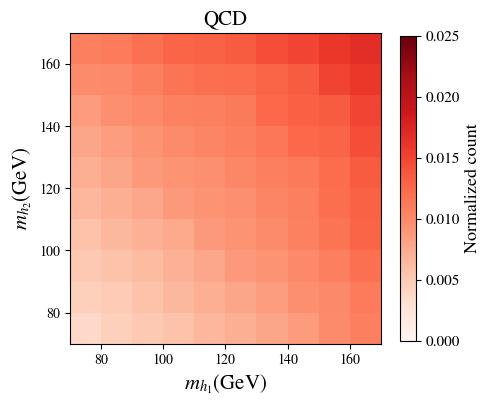

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import glob
import os
from multiprocessing import Pool, cpu_count
from functools import partial

# ===== Configuration =====
pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
model_names = [
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1",
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
]
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

lumi_scale = 4.5
weight_dict = {
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
}

cut_value = 0.9
cut_name = f"cut{str(cut_value).replace('.','p')}"

bins = np.arange(40, 201, 10)
n_bins = len(bins) - 1  # 16 bins

diag_indices = [0, 16, 31, 45, 58, 70, 81, 91, 100, 108, 115, 121, 126, 130, 133, 135]

# ===== Worker function for parallel processing =====
def process_single_file(file_info, pred_folder, model_names, weight, cut_value, diag_indices):
    """
    Process a single QCD file and return the 1D histogram contribution
    
    Parameters:
    -----------
    file_info : tuple
        (ifile, name) - input file path and name
    pred_folder : str
        Path to prediction folder
    model_names : list
        List of model names
    weight : float
        Event weight for QCD
    cut_value : float
        Score cut threshold
    diag_indices : list
        Diagonal indices for scaling
        
    Returns:
    --------
    h1d_local : np.array
        Local 1D histogram contribution (shape: 136)
    """
    ifile, name = file_info
    h1d_local = np.zeros(136)
    
    try:
        # Load predictions from all three models
        pred_data_list = []
        for model_name in model_names:
            pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
            pred_data_tmp = uproot.lazy(pred_file)
            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & 
                                     (pred_data_tmp['pass_4j3b_selection']==1)]
            pred_data_list.append(pred_data)
        
        n_events = len(pred_data_list[0])
        if n_events == 0:
            return h1d_local
        
        # Average scores across three models
        _scaledprobs = np.zeros((n_events, 136))
        scores_ALLHH4b = np.zeros(n_events)
        score_136 = np.zeros(n_events)
        score_137 = np.zeros(n_events)
        
        for pred_data in pred_data_list:
            for j in range(136):
                s = ak.to_numpy(pred_data[f'score_{j}'])
                _scaledprobs[:, j] += s / 3.0
                scores_ALLHH4b += s / 3.0
                
            score_136 += ak.to_numpy(pred_data['score_136']) / 3.0
            
            if 'score_137' in pred_data.fields:
                score_137 += ak.to_numpy(pred_data['score_137']) / 3.0

        _scaledprobs[:, diag_indices] *= 1.0
        
        denominator = scores_ALLHH4b + score_136 + score_137
        denominator[denominator == 0] = 1e-9
        
        score_hhvsboth = scores_ALLHH4b / denominator
        
        selection_mask = (score_hhvsboth > cut_value)
        
        if np.sum(selection_mask) > 0:
            selected_probs = _scaledprobs[selection_mask]
            
            row_sums = np.sum(selected_probs, axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            
            normalized_probs = selected_probs / row_sums
            
            bin_weights = weight * np.sum(normalized_probs, axis=0)
            
            h1d_local += bin_weights
            
        return h1d_local
            
    except Exception as e:
        print(f"\nError processing {name}: {e}")
        return h1d_local

# ===== Collect QCD files =====
print("Collecting QCD files...")
qcd_files = []
matching_folders = glob.glob(folder_pattern)

for ifolder in matching_folders:
    proc_name = ifolder.split("/")[-1].split("_")[0]
    if proc_name != "QCD": continue
    if "forInfer2" in ifolder: continue
    
    matching_files = glob.glob(ifolder + "/*")
    ext_folder = ifolder.replace("forInfer", "forInfer2")
    matching_files += glob.glob(ext_folder + "/*")
    
    for ifile in matching_files:
        if "forInfer2" in ifile:
            name = "QCDEXT_" + ifile.replace(".root", "").split("_")[-1]
        else:
            name = "QCD_" + ifile.replace(".root", "").split("_")[-1]
        qcd_files.append((ifile, name))

print(f"Found {len(qcd_files)} QCD files")

# ===== Parallel processing =====
weight = weight_dict["QCD"]
n_cores = 40

print(f"\nProcessing with {n_cores} cores...")

# Create partial function with fixed parameters
worker_func = partial(
    process_single_file,
    pred_folder=pred_folder,
    model_names=model_names,
    weight=weight,
    cut_value=cut_value,
    diag_indices=diag_indices
)

# Process files in parallel
with Pool(processes=n_cores) as pool:
    results = []
    for i, result in enumerate(pool.imap(worker_func, qcd_files)):
        results.append(result)
        print(f"\rProcessed {i+1}/{len(qcd_files)} files", end='', flush=True)

print("\n")

# ===== Combine results =====
h1d = np.zeros(136)
for result in results:
    h1d += result

print(f"1D histogram filled. Total Sum: {np.sum(h1d):.2f}")

# ===== Convert 1D to 2D histogram =====
H = np.zeros((n_bins, n_bins))
label_idx = 0

for i in range(n_bins):
    for j in range(i, n_bins):
        if label_idx < 136:
            H[i, j] = h1d[label_idx]
            label_idx += 1

# ===== Symmetrize =====
H_sym = (H + H.T) / 2

print(f"2D histogram sum: {np.sum(H_sym):.2f}")

# ===== Plot using make_single_plot =====
make_single_plot(H_sym, 'QCD', f'{cut_name}_classifier',vmax=0.025)


Found 557 QCD files

Processing with 40 cores using max_bin method...
Processed 557/557 files

1D histogram filled (max_bin method). Total Sum: 7066008.47
2D histogram sum: 7066008.47


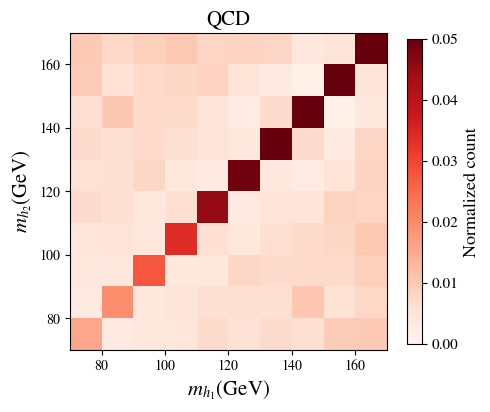

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import glob
import os
from multiprocessing import Pool, cpu_count
from functools import partial

# ===== Configuration =====
pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
model_names = [
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1",
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
]
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

lumi_scale = 4.5
weight_dict = {
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
}

cut_value = 0.9
cut_name = f"cut{str(cut_value).replace('.','p')}"

bins = np.arange(40, 201, 10)
n_bins = len(bins) - 1  # 16 bins

diag_indices = [0, 16, 31, 45, 58, 70, 81, 91, 100, 108, 115, 121, 126, 130, 133, 135]

# ===== Worker function for parallel processing =====
def process_single_file_maxbin(file_info, pred_folder, model_names, weight, cut_value, diag_indices):
    """
    Process a single QCD file using max_bin method and return the 1D histogram contribution
    
    Parameters:
    -----------
    file_info : tuple
        (ifile, name) - input file path and name
    pred_folder : str
        Path to prediction folder
    model_names : list
        List of model names
    weight : float
        Event weight for QCD
    cut_value : float
        Score cut threshold
    diag_indices : list
        Diagonal indices for scaling
        
    Returns:
    --------
    h1d_local : np.array
        Local 1D histogram contribution (shape: 136)
    """
    ifile, name = file_info
    h1d_local = np.zeros(136)
    
    try:
        # Load predictions from all three models
        pred_data_list = []
        all_models_exist = True
        
        for model_name in model_names:
            pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
            if not os.path.exists(pred_file):
                all_models_exist = False
                break
            pred_data_tmp = uproot.lazy(pred_file)
            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & 
                                     (pred_data_tmp['pass_4j3b_selection']==1)]
            pred_data_list.append(pred_data)
        
        if not all_models_exist:
            return h1d_local
        
        n_events = len(pred_data_list[0])
        if n_events == 0:
            return h1d_local
        
        # Check all models have same number of events
        if not all(len(pd) == n_events for pd in pred_data_list):
            return h1d_local
        
        # Step 1: Extract and ensemble scores 0-137 from all models
        ensemble_scores = np.zeros((n_events, 138))
        
        for pred_data in pred_data_list:
            for j in range(138):
                score_name = f'score_{j}'
                if score_name in pred_data.fields:
                    s = ak.to_numpy(pred_data[score_name])
                    ensemble_scores[:, j] += s
        
        # Average over models
        ensemble_scores /= len(model_names)
        
        # Extract ensemble scores for 0-135, 136, 137
        _scaledprobs = ensemble_scores[:, :136]
        score_136 = ensemble_scores[:, 136]
        score_137 = ensemble_scores[:, 137]
        
        # Step 2: Scale diagonal elements by 2
        _scaledprobs[:, diag_indices] *= 2.0
        
        # Step 3: Calculate discriminator score
        scores_ALLHH4b_scaled = np.sum(_scaledprobs, axis=1)
        denominator = scores_ALLHH4b_scaled + score_136 + score_137
        denominator[denominator == 0] = 1e-9
        
        score_hhvsboth = scores_ALLHH4b_scaled / denominator
        
        # Step 4: Apply cut_value selection
        selection_mask = (score_hhvsboth > cut_value)
        
        if np.sum(selection_mask) > 0:
            selected_probs = _scaledprobs[selection_mask]
            
            # Step 5: Find max bin index for each event
            max_bin_indices = np.argmax(selected_probs, axis=1)
            
            # Step 6: Fill histogram using np.bincount (vectorized, fast!)
            # np.bincount counts occurrences of each index
            # minlength=136 ensures output has exactly 136 bins
            bin_counts = np.bincount(max_bin_indices, minlength=136)
            h1d_local += bin_counts * weight
            
        return h1d_local
            
    except Exception as e:
        print(f"\nError processing {name}: {e}")
        return h1d_local

# ===== Collect QCD files =====
print("Collecting QCD files...")
qcd_files = []
matching_folders = glob.glob(folder_pattern)

for ifolder in matching_folders:
    proc_name = ifolder.split("/")[-1].split("_")[0]
    if proc_name != "QCD": continue
    if "forInfer2" in ifolder: continue
    
    matching_files = glob.glob(ifolder + "/*")
    ext_folder = ifolder.replace("forInfer", "forInfer2")
    matching_files += glob.glob(ext_folder + "/*")
    
    for ifile in matching_files:
        if "forInfer2" in ifile:
            name = "QCDEXT_" + ifile.replace(".root", "").split("_")[-1]
        else:
            name = "QCD_" + ifile.replace(".root", "").split("_")[-1]
        qcd_files.append((ifile, name))

print(f"Found {len(qcd_files)} QCD files")

# ===== Parallel processing =====
weight = weight_dict["QCD"]
n_cores = 40

print(f"\nProcessing with {n_cores} cores using max_bin method...")

# Create partial function with fixed parameters
worker_func = partial(
    process_single_file_maxbin,
    pred_folder=pred_folder,
    model_names=model_names,
    weight=weight,
    cut_value=cut_value,
    diag_indices=diag_indices
)

# Process files in parallel
with Pool(processes=n_cores) as pool:
    results = []
    for i, result in enumerate(pool.imap(worker_func, qcd_files)):
        results.append(result)
        print(f"\rProcessed {i+1}/{len(qcd_files)} files", end='', flush=True)

print("\n")

# ===== Combine results =====
h1d = np.zeros(136)
for result in results:
    h1d += result

print(f"1D histogram filled (max_bin method). Total Sum: {np.sum(h1d):.2f}")

# ===== Convert 1D to 2D histogram =====
H = np.zeros((n_bins, n_bins))
label_idx = 0

for i in range(n_bins):
    for j in range(i, n_bins):
        if label_idx < 136:
            H[i, j] = h1d[label_idx]
            label_idx += 1

# ===== Symmetrize =====
H_sym = (H + H.T) / 2

print(f"2D histogram sum: {np.sum(H_sym):.2f}")

# ===== Plot using make_single_plot =====
make_single_plot(H_sym, 'QCD', f'{cut_name}_maxbin',vmax=0.075)
